In [1]:
import numpy as np
import pyblp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import default_rng
from scipy.optimize import root
import scipy.sparse as sp


import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from pathlib import Path

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.2'

## Data Generation

In [ ]:
rng = default_rng(1999)

# ---------------------
# 1. Generate the data
# ---------------------
T = 600                         # number of markets
J = 4                           # four inside goods per market
N = T * J

market_id = np.repeat(np.arange(1, T + 1), J)
product_id = np.tile(np.arange(1, J + 1), T)

# Technology indicators: goods 1–2 satellite, goods 3–4 wired
satellite = (product_id <= 2).astype(int)
wired = (product_id >= 3).astype(int)

# Exogenous product characteristic and cost shifter
x = np.abs(rng.standard_normal(N))
w = np.abs(rng.standard_normal(N))

# Demand and cost unobservables drawn jointly:
# (xi_{jt}, omega_{jt}) ~ N(0, Sigma) with Sigma = [[1, 0.25], [0.25, 1]]
Sigma = np.array([[1.0, 0.25], [0.25, 1.0]])
L = np.linalg.cholesky(Sigma)
Z = rng.standard_normal((2, N))
xi, omega = (L @ Z)
xi = xi.ravel()
omega = omega.ravel()

# Structural parameters
TRUE_BETA1 = 1.0     # coefficient on quality x
TRUE_ALPHA = -2.0    # price coefficient
gamma0 = 0.5    # intercept in log marginal cost
gamma1 = 0.25   # slope on w in log marginal cost

# Random coefficients on satellite and on wired
TRUE_MU1 = 4.0
TRUE_MU2 = 4.0
TRUE_SIGMA1 = 1.0
TRUE_SIGMA2 = 1.0

products = pd.DataFrame(
    {
        "market_id": market_id,
        "product_id": product_id,
        "firm_id": product_id,   # single-product firms baseline
        "is_satellite": satellite,
        "is_wired": wired,
        "x": x,
        "w": w,
        "xi": xi,
        "omega": omega,
    }
)

# Master draws for random coefficients (fixed across ALL calls)
M_MASTER = 1000
beta2_draws_master = rng.normal(loc=TRUE_MU1, scale=TRUE_SIGMA1, size=M_MASTER)  # sat coeff
beta3_draws_master = rng.normal(loc=TRUE_MU2, scale=TRUE_SIGMA2, size=M_MASTER)  # wired coeff


# ---------------------------------------------------
# 2(a). Simulated conditional shares & Jacobian d s/d p
# ---------------------------------------------------
def conditional_shares_matrix(p, x, sat, wired, xi, TRUE_ALPHA, TRUE_BETA1, beta2_draws, beta3_draws):
    # Return a J x M matrix of conditional shares given prices p and random-coefficient draws.
    J = p.size
    M = beta2_draws.size
    V_base = TRUE_BETA1 * x + TRUE_ALPHA * p + xi
    S = np.empty((J, M))

    # Stabilized denominator with outside good utility normalized to 0
    for m in range(M):
        V = V_base + beta2_draws[m] * sat + beta3_draws[m] * wired
        vmax = max(0.0, V.max())
        log_den = np.log1p(np.exp(V - vmax).sum()) + vmax  # log(1 + sum exp(V))
        S[:, m] = np.exp(V - log_den)
    return S


def jacobian_dsdp_market(p, x, sat, wired, xi, TRUE_ALPHA, TRUE_BETA1, beta2_draws, beta3_draws):
    # Average Jacobian of shares with respect to prices (J x J) across simulated draws.
    S = conditional_shares_matrix(p, x, sat, wired, xi, TRUE_ALPHA, TRUE_BETA1, beta2_draws, beta3_draws)
    J_, M = S.shape
    acc = np.zeros((J_, J_))
    for m in range(M):
        sm = S[:, m]
        acc += TRUE_ALPHA * (np.diag(sm) - np.outer(sm, sm))
    return acc / M


def mean_shares_market(p, x, sat, wired, xi, TRUE_ALPHA, TRUE_BETA1, beta2_draws, beta3_draws):
    return conditional_shares_matrix(p, x, sat, wired, xi, TRUE_ALPHA, TRUE_BETA1, beta2_draws, beta3_draws).mean(axis=1)


# -------------------------------------------------------
# 2(c). Solve for equilibrium prices: two complementary ways
# -------------------------------------------------------
def _mc_from_df(df_t):
    # Log marginal cost: log c = gamma0 + gamma1 * w + omega / 8  ⇒  c = exp(log c).
    return np.exp(gamma0 + gamma1 * df_t["w"].to_numpy() + df_t["omega"].to_numpy() / 8.0)


def solve_prices_root_market(t, products, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=500, p0=None):
    # Root-finding on FOCs: p - mc - mu(p) = 0 where mu = -Δ^{-1} s.
    df_t = products.loc[products.market_id == t].copy()
    mc = _mc_from_df(df_t)
    J = len(df_t)
    if p0 is None:
        p0 = mc * 1.25
    d2 = beta2_master[:M]
    d3 = beta3_master[:M]

    x = df_t["x"].to_numpy()
    sat = df_t["is_satellite"].to_numpy()
    wir = df_t["is_wired"].to_numpy()
    xi = df_t["xi"].to_numpy()

    def F(p):
        s = mean_shares_market(p, x, sat, wir, xi, TRUE_ALPHA, TRUE_BETA1, d2, d3)
        Delta = jacobian_dsdp_market(p, x, sat, wir, xi, TRUE_ALPHA, TRUE_BETA1, d2, d3)
        mu = -np.linalg.solve(Delta, s)
        return p - mc - mu

    res = root(F, p0, method="hybr")
    return {"prices": res.x, "converged": res.success, "iterations": res.nfev, "method": "root"}


def solve_prices_ms_market(t, products, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=500, tol=1e-8, maxit=20000, p0=None):
    # Morrow–Skerlos ζ-iteration for single-product firms.
    df_t = products.loc[products.market_id == t].copy()
    mc = _mc_from_df(df_t)
    J = len(df_t)
    p = p0.copy() if p0 is not None else mc * 1.25
    zeta = p - mc

    d2 = beta2_master[:M]
    d3 = beta3_master[:M]

    x = df_t["x"].to_numpy()
    sat = df_t["is_satellite"].to_numpy()
    wir = df_t["is_wired"].to_numpy()
    xi = df_t["xi"].to_numpy()

    converged = False
    it = 0
    while it < maxit:
        it += 1

        S = conditional_shares_matrix(p, x, sat, wir, xi, TRUE_ALPHA, TRUE_BETA1, d2, d3)
        s = S.mean(axis=1)
        s = np.clip(s, 1e-12, 1.0)  # protect against underflow
        Lambda = TRUE_ALPHA * s
        Gamma = TRUE_ALPHA * (S @ S.T) / M

        zeta_new = (Gamma @ zeta - s) / Lambda
        p_new = mc + zeta_new

        r = s + Lambda * zeta_new - Gamma @ zeta_new
        if np.max(np.abs(r)) < tol:
            converged = True
            zeta = zeta_new
            p = p_new
            break

        zeta = zeta_new
        p = p_new

    return {"prices": p, "converged": converged, "iterations": it, "method": "MS"}


def solve_all_markets(products, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=500, method="root"):
    out = []
    for t in np.unique(products.market_id):
        if method == "root":
            res = solve_prices_root_market(t, products, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=M)
        elif method == "ms":
            res = solve_prices_ms_market(t, products, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=M)
        else:
            raise ValueError("Unknown method: choose 'root' or 'ms'")
        out.append({"market": int(t), **res})
    return out


def write_observed_shares(products, results, TRUE_ALPHA, TRUE_BETA1, beta2_master, beta3_master, M=500,
                          price_col="p_eq_ms", share_col="s_obs_ms"):
    products[price_col] = np.nan
    products[share_col] = np.nan
    d2 = beta2_master[:M]
    d3 = beta3_master[:M]
    for r in results:
        t = r["market"]
        idx = products.market_id == t
        df_t = products.loc[idx]
        p = r["prices"]
        s = mean_shares_market(
            p,
            df_t["x"].to_numpy(),
            df_t["is_satellite"].to_numpy(),
            df_t["is_wired"].to_numpy(),
            df_t["xi"].to_numpy(),
            TRUE_ALPHA,
            TRUE_BETA1,
            d2,
            d3,
        )
        products.loc[idx, price_col] = p
        products.loc[idx, share_col] = s


# ----------------------------------------
# 3. Simulate equilibrium and “observed” shares
# ----------------------------------------
results_root = solve_all_markets(products, TRUE_ALPHA, TRUE_BETA1, beta2_draws_master, beta3_draws_master, M=500, method="root")
results_ms = solve_all_markets(products, TRUE_ALPHA, TRUE_BETA1, beta2_draws_master, beta3_draws_master, M=500, method="ms")

# (Optional) check that both methods agree closely
max_diff = np.max(
    np.concatenate(
        [np.abs(r["prices"] - m["prices"]) for r, m in zip(results_root, results_ms)]
    )
)
print(f"Max |Δp| across markets (root vs MS) = {max_diff:.3e}")

# Build “observed” shares from MS equilibrium
write_observed_shares(
    products, results_ms, TRUE_ALPHA, TRUE_BETA1, beta2_draws_master, beta3_draws_master,
    M=500, price_col="p_eq_ms", share_col="s_obs_ms"
)



In [ ]:
products.rename(columns={"s_obs_ms": "shares", "p_eq_ms": "prices", "market_id": "market_ids", "firm_id": "firm_ids", "product_id": "product_ids"}, inplace=True)
mc = np.exp(gamma0 + gamma1 * w + omega / 8.0)  # shape (T, J)
products["mc"] = mc
data = pd.DataFrame.from_records(products)
for c in data.columns:
    data[c] = pd.to_numeric(data[c])
data.to_csv("simulated_data.csv", index=False)
print(data.head())
prices_root = np.array([results_root[t]["prices"] for t in range(len(results_root))])
shares_root = products["shares"].to_numpy().reshape(T, J)

   market_ids  product_ids  firm_ids  is_satellite  is_wired         x  \
0           1            1         1             1         0  0.788731   
1           1            2         2             1         0  0.983685   
2           1            3         3             0         1  0.463851   
3           1            4         4             0         1  0.181903   
4           2            1         1             1         0  0.138110   

          w        xi     omega    prices    shares        mc  
0  0.795694 -2.366689  1.811686  3.540680  0.004100  2.522838  
1  0.808676  0.395860 -0.854119  2.831606  0.325952  1.813764  
2  0.169128 -0.644240 -0.698141  2.595471  0.136000  1.576196  
3  1.466597  1.536781  3.155258  4.548424  0.018280  3.529149  
4  1.035528  0.681866  0.821282  3.440901  0.044921  2.366808  


C:\Users\stefa\AppData\Local\Temp\ipykernel_41104\3876883713.py:4: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  data = pd.DataFrame.from_records(products)


import numpy as np
import matplotlib.pyplot as plt

def avg_ownprice_deriv_vs_R(
    x, xi, prices, is_sat, is_wir,
    R_grid=(10, 20, 50, 100, 200, 500, 1000),
    rng_seed=1234,
    product_index=0,
    TRUE_BETA1=TRUE_BETA1,     # 1.0
    TRUE_ALPHA=TRUE_ALPHA,     # -2.0
    mu2=TRUE_MU1,         # 4.0  (satellite mean taste)
    sd2=TRUE_SIGMA1,         # 1.0  (satellite sd)
    mu3=TRUE_MU2,         # 4.0  (wired mean taste)
    sd3=TRUE_SIGMA2          # 1.0  (wired sd)
):
    """
    For each R in R_grid:
      - simulate demand in every market
      - compute ds_j/dp_j for product_index in that market
      - average across markets
    Returns:
      R_list, avg_deriv_list
    """
    rng = np.random.default_rng(rng_seed)
    T, J = prices.shape
    sat_vec = is_sat.astype(float)
    wir_vec = is_wir.astype(float)

    avg_derivs = []

    for R in R_grid:
        own_derivs_this_R = []

        # draw consumer tastes ONCE per R so the same random pool is reused in all markets
        beta2_i = mu2 + sd2 * rng.standard_normal(R)  # taste for satellite
        beta3_i = mu3 + sd3 * rng.standard_normal(R)  # taste for wired

        for t in range(T):
            p_t   = prices[t]    # (J,)
            x_t   = x[t]         # (J,)
            xi_t  = xi[t]        # (J,)

            # deterministic part of utility δ_j = TRUE_BETA1*x_j + TRUE_ALPHA*p_j + xi_j
            delta = TRUE_BETA1 * x_t + TRUE_ALPHA * p_t + xi_t  # (J,)

            # μ_ij = beta2_i * sat_j + beta3_i * wir_j  -> shape (R,J)
            mu_ij = (np.outer(beta2_i, sat_vec) +
                     np.outer(beta3_i, wir_vec))      # (R,J)

            # full utility draw-by-draw for inside goods
            V_ij = delta[None, :] + mu_ij            # (R,J)

            # add outside good with utility 0
            V_full = np.concatenate(
                [np.zeros((R,1)), V_ij],
                axis=1
            )                                        # (R,J+1)

            # logit probs
            Vc = V_full - V_full.max(axis=1, keepdims=True)
            expV = np.exp(Vc)
            denom = expV.sum(axis=1, keepdims=True)
            P_full = expV / denom                    # (R,J+1)

            # keep inside-good probs only
            P_in = P_full[:, 1:]                     # (R,J)

            # build Jacobian ds/dp for this market at this R
            # dP_{i,j}/dp_k = TRUE_ALPHA * P_{i,j} * (1{j==k} - P_{i,k})
            dsdp = np.zeros((J, J))
            for k in range(J):
                Pk = P_in[:, k]                      # (R,)
                for j in range(J):
                    Pj = P_in[:, j]                  # (R,)
                    ind = 1.0 if (j == k) else 0.0
                    dPj_dpk = TRUE_ALPHA * Pj * (ind - Pk)
                    dsdp[j, k] = dPj_dpk.mean()

            # own-price slope for the chosen product in this market
            own_derivs_this_R.append(dsdp[product_index, product_index])

        # average across all markets
        avg_derivs.append(np.mean(own_derivs_this_R))

    return list(R_grid), avg_derivs


def plot_convergence_avg(R_grid, deriv_vals, product_label=0):
    plt.figure()
    plt.plot(R_grid, deriv_vals, marker='o')
    plt.xlabel("Number of simulation draws R")
    plt.ylabel(rf"Avg across markets: $\partial s_{{{product_label+1}}}/ \partial p_{{{product_label+1}}}$")
    plt.title("Average own-price slope convergence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


R_grid, deriv_vals = avg_ownprice_deriv_vs_R(
    x=x,
    xi=xi,
    prices=prices_root,
    is_sat=is_sat,
    is_wir=is_wir,
    R_grid=(10, 20, 50, 100, 200, 500, 1000),
    rng_seed=1234,
    product_index=0  # track product 1 (index 0)
)

print("R vs avg own-price derivative ds1/dp1 across markets:")
for R, dv in zip(R_grid, deriv_vals):
    print(R, dv)

plot_convergence_avg(R_grid, deriv_vals, product_label=0)


### Estimate Some Mis-specified Models

In [ ]:
ln_s_0t = - np.log(1.0 - shares_root.sum(axis=1))  # (T,)
diff_ln_s_jt = np.log(shares_root) - np.repeat(ln_s_0t[:, None], J, axis=1)  # (T,J)

diff_ln_s_jt_vec = diff_ln_s_jt.flatten()  # (T*J,)

X = [data['x'].values, data["is_satellite"].values, data['prices'].values]
X_mat = np.column_stack(X)
model = sm.OLS(diff_ln_s_jt_vec, X_mat)
results_OLS = model.fit()
print(results_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              9452.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):                        0.00
Time:                        00:10:44   Log-Likelihood:                         -3360.2
No. Observations:                2400   AIC:                                      6726.
Df Residuals:                    2397   BIC:                                      6744.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 5

In [ ]:
data_IV = pd.DataFrame({
    "y":        pd.Series(diff_ln_s_jt_vec).astype(float),
    "x":        pd.Series(data["x"]).astype(float),
    "prices":   pd.Series(data["prices"]).astype(float),
    "w":        pd.Series(data["w"]).astype(float),
    "is_satellite": pd.Series(data["is_satellite"]).astype(int)  # 0/1
}).dropna()

results_IV = IV2SLS.from_formula(
    "y ~ x + is_satellite + [prices ~ w]",
    data=data_IV
).fit(cov_type="robust")

print(results_IV.summary)   # note: no parentheses


                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.9210
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9209
No. Observations:                2400   F-statistic:                 2.195e+04
Date:                Mon, Oct 27 2025   P-value (F-stat)                0.0000
Time:                        00:10:44   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
x                0.8623     0.0400     21.575     0.0000      0.7840      0.9406
is_satellite     0.1622     0.0446     3.637

In [ ]:
def grab(series_like, name):
    """Safely pick coefficient by name; return NaN if missing."""
    try:
        return float(series_like[name])
    except Exception:
        return np.nan

row_order = [
    ("$\\TRUE_ALPHA$ (price)", "prices"),
    ("$\\beta_1$ (x)", "x"),
    ("$\\beta_2$ (satellite)", "is_satellite")
]

table_data = pd.DataFrame(
    {
        "True value": [
            TRUE_ALPHA,
            TRUE_BETA1,
            " "
        ],
        "OLS": [
            results_OLS.params[2],
            results_OLS.params[0],
            results_OLS.params[1],
        ],
        "IV-2SLS (robust)": [
            grab(results_IV.params, "prices"),
            grab(results_IV.params, "x"),
            grab(results_IV.params, "is_satellite"),
        ],
    },
    index=[r[0] for r in row_order],
)

# (Optional) add SEs as extra rows; comment out if you prefer a compact table
add_ses = True
if add_ses:
    se_rows = pd.DataFrame(
        {
            "True value": ["", "", ""],
            "OLS": [
                results_OLS.bse[2],
                results_OLS.bse[0],
                results_OLS.bse[1],
            ],
            "IV-2SLS (robust)": [
                grab(results_IV.std_errors, "prices"),
                grab(results_IV.std_errors, "x"),
                grab(results_IV.std_errors, "is_satellite"),
            ],
        },
        index=[r + " (s.e.)" for r in [ro[0] for ro in row_order]],
    )
    table_data = pd.concat([table_data, se_rows], axis=0)

# ===============================
# 5) Write LaTeX to file
# ===============================
out_path = Path("latex/table_exercise_4.tex").resolve()
latex_str = table_data.to_latex(
    index=True,
    float_format="%.3f",
    column_format="lccc",
    caption="True parameters vs. OLS and IV-2SLS estimates",
    label="tab:exercise_4",
    escape=False
)
out_path.write_text(latex_str, encoding="utf-8")
print(f"\nLaTeX table written to: {out_path}")

# If you prefer to also save a CSV for quick checking:
table_data.to_csv("latex/table_exercise_4.csv", index=True)
print("CSV written to: latex/table_exercise_4.csv")


LaTeX table written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_4.tex
CSV written to: latex/table_exercise_4.csv


### 6

In [ ]:
df_exercise_6 = pd.read_csv("simulated_data.csv")

# 1) Outside share and log share ratio
mkt_sum = df_exercise_6.groupby("market_ids")["shares"].sum().rename("sum_share_mkt")
df_exercise_6 = df_exercise_6.merge(mkt_sum, on="market_ids", how="left")
df_exercise_6["s0"] = (1.0 - df_exercise_6["sum_share_mkt"]).clip(lower=1e-12)
df_exercise_6["ln_sj_s0"] = np.log(df_exercise_6["shares"].clip(lower=1e-12)) - np.log(df_exercise_6["s0"])

# 2) Boolean masks for nests
mask_sat = df_exercise_6["is_satellite"].astype(bool)
mask_wir = df_exercise_6["is_wired"].astype(bool)

# 3) Nest totals S_{g,t}
S_sat = (df_exercise_6.assign(sat_share=np.where(mask_sat, df_exercise_6["shares"], 0.0))
           .groupby("market_ids")["sat_share"].transform("sum"))
S_wir = (df_exercise_6.assign(wir_share=np.where(mask_wir, df_exercise_6["shares"], 0.0))
           .groupby("market_ids")["wir_share"].transform("sum"))

# 4) Within-nest logs (0 for products not in that nest)
df_exercise_6["ln_within_sat"] = 0.0
valid_sat = mask_sat & (S_sat > 0)
df_exercise_6.loc[valid_sat, "ln_within_sat"] = np.log((df_exercise_6.loc[valid_sat, "shares"] / S_sat[valid_sat]).clip(lower=1e-12))

df_exercise_6["ln_within_wired"] = 0.0
valid_wir = mask_wir & (S_wir > 0)
df_exercise_6.loc[valid_wir, "ln_within_wired"] = np.log((df_exercise_6.loc[valid_wir, "shares"] / S_wir[valid_wir]).clip(lower=1e-12))


formula = (
    "ln_sj_s0 ~  x + ln_within_sat + ln_within_wired "
    "[prices ~ w]"
)
iv_res = IV2SLS.from_formula(formula, data=df_exercise_6).fit(
    cov_type="clustered", clusters=df_exercise_6["market_ids"]
)
print(iv_res.summary)

# Coefs
beta_x    = iv_res.params["x"]
alpha_p   = iv_res.params["prices"]
sigma_sat = iv_res.params["ln_within_sat"]
sigma_wir = iv_res.params["ln_within_wired"]
print("\nEstimates:")
print(f"Beta on x           = {beta_x:.4f}")
print(f"Alpha on prices     = {alpha_p:.4f}")
print(f"Sigma (satellite)   = {sigma_sat:.4f}")
print(f"Sigma (wired)       = {sigma_wir:.4f}")

                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_sj_s0   R-squared:                      0.9235
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9234
No. Observations:                2400   F-statistic:                 4.908e+04
Date:                Mon, Oct 27 2025   P-value (F-stat)                0.0000
Time:                        00:10:44   Distribution:                  chi2(4)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
x                   0.6346     0.0388     16.343     0.0000      0.5585      0.7107
ln_within_sat       0.6901     0

In [ ]:
# CREATE LATEX TABLE
table_data = pd.DataFrame(
    {
        "IV-2SLS": [
            float(iv_res.params["prices"]),
            float(iv_res.params["x"]),
            float(iv_res.params["ln_within_sat"]),
            float(iv_res.params["ln_within_wired"]),
        ],
    },
    index=[
        r"$\TRUE_ALPHA$ (price)",
        r"$\beta_1$ (x)",
        r"$\sigma_{satellite}$",
        r"$\sigma_{wired}$"
    ],
).astype(float)

out_path = Path("latex/table_exercise_6.tex").resolve()
latex_str = table_data.to_latex(
    index=True,
    float_format="%.3f",
    column_format="lccc",
    caption="Nested logit IV-2SLS estimates",
    label="tab:exercise_6",
    escape=False
)
out_path.write_text(latex_str, encoding="utf-8")
print(f"\nLaTeX table written to: {out_path}")



LaTeX table written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_6.tex


### 7

df_exercise_7 = pd.read_csv("simulated_data.csv")


# ---------- grab estimated parameters from IV ----------
alpha_hat      = float(iv_res.params.get("prices", np.nan))
sigma_sat_hat  = float(iv_res.params.get("ln_within_sat", np.nan))
sigma_wir_hat  = float(iv_res.params.get("ln_within_wired", np.nan))

# ---------- prep data ----------
eps = 1e-12
df_exercise_7["shares"]  = df_exercise_7["shares"].astype(float).clip(lower=eps)
df_exercise_7["prices"]  = df_exercise_7.get("prices", df_exercise_7.get("price")).astype(float)
df_exercise_7["is_satellite"] = df_exercise_7["is_satellite"].astype(int)
df_exercise_7["is_wired"]     = df_exercise_7["is_wired"].astype(int)

# market nest totals and within-nest shares
df_exercise_7["S_sat"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_satellite"]).sum()
).clip(lower=eps)
df_exercise_7["S_wir"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_wired"]).sum()
).clip(lower=eps)

df_exercise_7["s_within"] = np.where(df_exercise_7["is_satellite"]==1,
                          df_exercise_7["shares"]/df_exercise_7["S_sat"],
                          df_exercise_7["shares"]/df_exercise_7["S_wir"])


# ---------- (1) own-price elasticities ----------
def own_elasticity(TRUE_ALPHA, sigma_sat, sigma_wir, df):
    # pick the right nesting parameter for each product
    sig = np.where(df["is_satellite"] == 1, sigma_sat, sigma_wir)

    # s_within = s_{j|g}
    # formula: -α * p_j * [1 - σ_g * (1 - s_{j|g})]
    return -TRUE_ALPHA * df["prices"] * (1 - sig * (1 - df["s_within"]))

df_exercise_7["elasticity_est"]  = own_elasticity(alpha_hat,  sigma_sat_hat,  sigma_wir_hat, df_exercise_7)


In [ ]:
print("alpha_hat =", alpha_hat)
print("sigma_sat_hat =", sigma_sat_hat)
print("sigma_wir_hat =", sigma_wir_hat)


alpha_hat = -0.5249870585139504
sigma_sat_hat = 0.690113318004494
sigma_wir_hat = 0.6913152316634754


In [ ]:
df_exercise_7 = pd.read_csv("simulated_data.csv")
alpha_hat      = float(iv_res.params.get("prices", np.nan))
sigma_sat_hat  = float(iv_res.params.get("ln_within_sat", np.nan))
sigma_wir_hat  = float(iv_res.params.get("ln_within_wired", np.nan))

eps = 1e-12
df_exercise_7["shares"]  = df_exercise_7["shares"].astype(float).clip(lower=eps)
df_exercise_7["prices"]  = df_exercise_7.get("prices", df_exercise_7.get("price")).astype(float)
df_exercise_7["is_satellite"] = df_exercise_7["is_satellite"].astype(int)
df_exercise_7["is_wired"]     = df_exercise_7["is_wired"].astype(int)

# market nest totals and within-nest shares
df_exercise_7["S_sat"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_satellite"]).sum()
).clip(lower=eps)
df_exercise_7["S_wir"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_wired"]).sum()
).clip(lower=eps)

df_exercise_7["s_within"] = np.where(df_exercise_7["is_satellite"]==1,
                          df_exercise_7["shares"]/df_exercise_7["S_sat"],
                          df_exercise_7["shares"]/df_exercise_7["S_wir"])

def nested_logit_own_price_elasticity(df, alpha_hat, sigma_sat_hat, sigma_wir_hat):
    sigma_g = np.where(df["is_satellite"] == 1, sigma_sat_hat, sigma_wir_hat)

    s_j      = df["shares"].to_numpy()     # s_j
    s_within = df["s_within"].to_numpy()   # s_{j|g}
    p_j      = df["prices"].to_numpy()     # p_j

    term_within  = (1.0 - sigma_g) * (1.0 - s_within)   # (1-σ_g)(1 - s_{j|g})
    term_outside = sigma_g * (1.0 - s_j)                # σ_g(1 - s_j)

    # THIS is the corrected sign:
    elasticity = alpha_hat * p_j * (term_within + term_outside)

    return pd.Series(elasticity, index=df.index)


df_exercise_7["elasticity_est"] = nested_logit_own_price_elasticity(
    df_exercise_7,
    alpha_hat=alpha_hat,
    sigma_sat_hat=sigma_sat_hat,
    sigma_wir_hat=sigma_wir_hat
)



In [ ]:

def compute_true_elasticities(df, R=1000, seed=42):
    """
    Compute true own-price elasticities for each product-market pair.
    df must contain: market_id, product_id, x, price, xi, is_satellite, is_wired
    """
    rng = np.random.default_rng(seed)
    elasticities = []

    # draw random consumer tastes (heterogeneity)
    beta_sat_i = rng.normal(loc=4.0, scale=1.0, size=R)
    beta_wir_i = rng.normal(loc=4.0, scale=1.0, size=R)

    for mkt, mkt_df in df.groupby("market_ids"):
        x = mkt_df["x"].to_numpy()
        p = mkt_df["prices"].to_numpy()
        xi = mkt_df["xi"].to_numpy()
        is_sat = mkt_df["is_satellite"].to_numpy()
        is_wir = mkt_df["is_wired"].to_numpy()

        J = len(x)
        v = np.zeros((R, J))  # deterministic utility part for each consumer

        for j in range(J):
            v[:, j] = (
                TRUE_BETA1 * x[j]
                + beta_sat_i * is_sat[j]
                + beta_wir_i * is_wir[j]
                + TRUE_ALPHA * p[j]
                + xi[j]
            )

        # choice probabilities for each consumer (softmax)
        exp_v = np.exp(v)
        denom = 1 + exp_v.sum(axis=1, keepdims=True)  # include outside option
        s_ijt = exp_v / denom  # shape (R, J)

        # aggregate (average) market shares
        s_jt = s_ijt.mean(axis=0)  # (J,)

        # derivative term E_i[s_ijt(1 - s_ijt)]
        deriv_term = (s_ijt * (1 - s_ijt)).mean(axis=0)  # (J,)

        # own-price elasticities
        elasticities_jt = TRUE_ALPHA * deriv_term * (p / s_jt)

        for j, e in enumerate(elasticities_jt):
            elasticities.append({
                "market_ids": mkt,
                "product_is": mkt_df.iloc[j]["product_ids"],
                "elasticity_true": e
            })

    return pd.DataFrame(elasticities)


elasticities  = compute_true_elasticities(df_exercise_7)
df_exercise_7["elasticity_true"] = elasticities["elasticity_true"]

In [ ]:
# mean True elasiticity and Estimated elasticity by product
mean_elasticities = df_exercise_7.groupby("product_ids").agg(
    mean_elasticity_true = ("elasticity_true", "mean"),
    mean_elasticity_est  = ("elasticity_est", "mean")
    
).reset_index()

mean_elasticities.rename(columns={"product_ids": "Product", "mean_elasticity_true": "Mean True Elasticity", "mean_elasticity_est": "Mean Estimated Elasticity"}, inplace=True)
elasticity_true = mean_elasticities["Mean True Elasticity"].values

mean_elasticities.to_latex(
    "latex/table_exercise_7.tex",
    index=False, float_format="%.4f",
    caption="Summary: True vs. Estimated Parameters and Elasticities",
    label="tab:exercise_7"
)

In [ ]:
mean_elasticities

,Product,Mean True Elasticity,Mean Estimated Elasticity
0,1,-5.087001,-1.266241
1,2,-5.138258,-1.285113
2,3,-5.109882,-1.275023
3,4,-5.062144,-1.265516


In [ ]:
def recover_xi_hat(df_mkt, beta_x, alpha_p, sigma_sat, sigma_wir, eps=1e-12):
    """
    For one market:
    Use the estimating equation
        ln(s_j/s0) = beta_x * x_j + alpha_p * p_j
                      + sigma_sat * ln_within_sat_j
                      + sigma_wir * ln_within_wired_j
                      + xi_j
    and solve for xi_j product-by-product:
        xi_j = ln(s_j/s0) - ( ... )
    This gives us xi_hat, which we'll treat as delta_j's unobserved quality.
    """
    ln_sj_s0 = df_mkt["ln_sj_s0"].to_numpy()

    part_obs = (
        beta_x * df_mkt["x"].to_numpy()
        + alpha_p * df_mkt["prices"].to_numpy()
        + sigma_sat * df_mkt["ln_within_sat"].to_numpy()
        + sigma_wir * df_mkt["ln_within_wired"].to_numpy()
    )

    xi_hat = ln_sj_s0 - part_obs
    return xi_hat  # array length J


def nested_logit_shares_one_market(df_mkt, beta_x, alpha_p,
                                   sigma_sat, sigma_wir,
                                   eps=1e-12):
    """
    Compute predicted nested-logit inside-good shares for ONE market t,
    using your estimated parameters AND the recovered xi_hat from that market.

    Returns:
      shares_pred: np.array length J with predicted inside-good shares
      s0_pred: float, predicted outside share
    """

    # 1. recover xi_hat for this market from your estimating eq
    xi_hat = recover_xi_hat(
        df_mkt,
        beta_x=beta_x,
        alpha_p=alpha_p,
        sigma_sat=sigma_sat,
        sigma_wir=sigma_wir,
        eps=eps
    )

    # 2. construct delta_j = beta_x * x_j + alpha_p * p_j + xi_hat
    x_j   = df_mkt["x"].to_numpy()
    p_j   = df_mkt["prices"].to_numpy()
    is_sat = df_mkt["is_satellite"].to_numpy().astype(bool)
    is_wir = df_mkt["is_wired"].to_numpy().astype(bool)

    delta_j = beta_x * x_j + alpha_p * p_j + xi_hat

    # 3. For each nest g, build A_g = sum exp(delta/(1-sigma_g))
    #    and IV_g = A_g^(1 - sigma_g)

    # satellite nest
    denom_sat = 1.0 - sigma_sat
    if denom_sat <= 0:
        raise ValueError("sigma_sat must be < 1 for nested logit.")
    delta_sat = delta_j[is_sat]
    if delta_sat.size > 0:
        exp_term_sat = np.exp(delta_sat / denom_sat)
        A_sat = exp_term_sat.sum()
        IV_sat = (A_sat ** denom_sat)
    else:
        A_sat = 0.0
        IV_sat = 0.0

    # wired nest
    denom_wir = 1.0 - sigma_wir
    if denom_wir <= 0:
        raise ValueError("sigma_wir must be < 1 for nested logit.")
    delta_wir = delta_j[is_wir]
    if delta_wir.size > 0:
        exp_term_wir = np.exp(delta_wir / denom_wir)
        A_wir = exp_term_wir.sum()
        IV_wir = (A_wir ** denom_wir)
    else:
        A_wir = 0.0
        IV_wir = 0.0

    # 4. denominator including outside
    denom_full = 1.0 + IV_sat + IV_wir  # outside utility normalized to 0 → exp(0)=1
    denom_full = max(denom_full, eps)

    # 5. nest probabilities
    P_sat = IV_sat / denom_full if IV_sat > 0 else 0.0
    P_wir = IV_wir / denom_full if IV_wir > 0 else 0.0

    # 6. conditional within-nest choice probabilities
    shares_pred = np.zeros_like(delta_j)

    if delta_sat.size > 0 and A_sat > 0 and P_sat > 0:
        s_j_given_sat = np.exp(delta_sat / denom_sat) / max(A_sat, eps)
        shares_pred[is_sat] = P_sat * s_j_given_sat

    if delta_wir.size > 0 and A_wir > 0 and P_wir > 0:
        s_j_given_wir = np.exp(delta_wir / denom_wir) / max(A_wir, eps)
        shares_pred[is_wir] = P_wir * s_j_given_wir

    # 7. outside share prediction
    s0_pred = 1.0 / denom_full

    return shares_pred, s0_pred

def compute_nested_logit_elasticities_one_market(df_mkt,
                                                 beta_x, alpha_p,
                                                 sigma_sat, sigma_wir,
                                                 eps=1e-12):
    """
    Compute estimated nested-logit own-price elasticities for ONE market,
    using the IV estimates and the nested-logit share reconstruction machinery
    you already wrote.

    Returns:
      DataFrame with columns:
      market_ids, product_ids, elasticity_hat
    """

    # 1. Predict shares via your nested logit structure
    shares_pred, s0_pred = nested_logit_shares_one_market(
        df_mkt,
        beta_x=beta_x,
        alpha_p=alpha_p,
        sigma_sat=sigma_sat,
        sigma_wir=sigma_wir,
        eps=eps
    )
    # shares_pred is length J, aligned with df_mkt rows (after reset_index in caller)

    # 2. Compute nest-level totals
    is_sat = df_mkt["is_satellite"].to_numpy().astype(bool)
    is_wir = df_mkt["is_wired"].to_numpy().astype(bool)

    share_sat = shares_pred[is_sat].sum()
    share_wir = shares_pred[is_wir].sum()

    # 3. Loop product-by-product and build elasticity using NL formula
    out_rows = []
    prices = df_mkt["prices"].to_numpy()

    for j in range(len(df_mkt)):
        s_j = shares_pred[j]
        if s_j < eps:
            elas_j = np.nan
        else:
            if is_sat[j]:
                sigma_g = sigma_sat
                s_g = share_sat
            elif is_wir[j]:
                sigma_g = sigma_wir
                s_g = share_wir
            else:
                # If you ever have a product that's in neither nest,
                # fall back to simple logit formula. (Probably not your case.)
                sigma_g = 0.0
                s_g = s_j

            s_j_given_g = s_j / max(s_g, eps)

            # derivative formula
            slope_j = alpha_p * s_j * (
                (1 - sigma_g) * (1 - s_j) + sigma_g * (1 - s_j_given_g)
            )

            elas_j = slope_j * (prices[j] / s_j)

        out_rows.append({
            "market_ids": df_mkt.loc[j, "market_ids"],
            "product_ids": df_mkt.loc[j, "product_ids"],
            "elasticity_hat_nestedlogit": elas_j,
            "share_hat_nested": s0_pred
        })

    return pd.DataFrame(out_rows)


def compute_nested_logit_elasticities_all_markets(data, iv_res, eps=1e-12):
    beta_x    = iv_res.params["x"]
    alpha_p   = iv_res.params["prices"]
    sigma_sat = iv_res.params["ln_within_sat"]
    sigma_wir = iv_res.params["ln_within_wired"]

    out_list = []
    for mkt, df_mkt in data.groupby("market_ids"):
        df_mkt = df_mkt.reset_index(drop=True)
        out_list.append(
            compute_nested_logit_elasticities_one_market(
                df_mkt,
                beta_x=beta_x,
                alpha_p=alpha_p,
                sigma_sat=sigma_sat,
                sigma_wir=sigma_wir,
                eps=eps
            )
        )
    return pd.concat(out_list, ignore_index=True)


In [ ]:
df_pred = compute_nested_logit_elasticities_all_markets(df_exercise_6, iv_res)


In [ ]:
df_exercise_7 = df_exercise_7.merge(df_pred, on=["market_ids", "product_ids"], how="left")


In [ ]:
def compute_true_diversion_matrix(df, R=1000, seed=42):
    """
    Compute the *true* diversion ratios D_{i->j} for each market
    under the DGP you used in compute_true_elasticities.

    df must contain, at least:
        market_ids, product_ids, x, prices, xi,
        is_satellite, is_wired

    Returns:
        dict mapping market_id -> pandas.DataFrame (J x (J+1)):
            rows i = product whose price increases
            cols j = product that gains demand (including outside as column 'outside')
            diagonal D_{i->i} = 0 by convention
    """
    rng = np.random.default_rng(seed)

    diversion_by_market = {}

    # draw heterogeneity once (same consumers across markets, like a panel of taste draws)
    beta_sat_i = rng.normal(loc=4.0, scale=1.0, size=R)
    beta_wir_i = rng.normal(loc=4.0, scale=1.0, size=R)

    for mkt, mkt_df in df.groupby("market_ids"):
        mkt_df = mkt_df.reset_index(drop=True)

        x      = mkt_df["x"].to_numpy()
        p      = mkt_df["prices"].to_numpy()
        xi     = mkt_df["xi"].to_numpy()
        is_sat = mkt_df["is_satellite"].to_numpy()
        is_wir = mkt_df["is_wired"].to_numpy()

        J = len(mkt_df)

        # utilities v[r,j]
        v = np.zeros((R, J))
        for j in range(J):
            v[:, j] = (
                TRUE_BETA1 * x[j]
                + beta_sat_i * is_sat[j]
                + beta_wir_i * is_wir[j]
                + TRUE_ALPHA * p[j]
                + xi[j]
            )

        # choice probs for each consumer r across inside goods + outside
        exp_v = np.exp(v)                      # R x J
        denom = 1.0 + exp_v.sum(axis=1, keepdims=True)  # R x 1
        s_rj  = exp_v / denom                  # R x J  (inside goods)
        s_r0  = 1.0 / denom.squeeze()          # R, outside prob for each consumer

        # We'll build a (J x (J+1)) diversion matrix.
        # Columns 0..J-1 are inside products j,
        # Column J is outside option.
        numer = np.zeros((J, J+1))
        denom_vec = np.zeros(J)

        # Precompute averages we need:
        # avg over r of s_rj * s_ri  for all i,j
        # We'll do this with matrix multiplications.
        # s_rj: R x J
        # We want for each i,j: mean_r [ s_r[:,j] * s_r[:,i] ]
        # That's basically (s_rj.T @ s_rj)/R
        cross_term = (s_rj.T @ s_rj) / R  # J x J

        # For outside column: mean_r[ s_r0 * s_r[:,i] ]
        outside_term = (s_rj.T @ s_r0.reshape(-1,1)) / R  # J x 1

        # Denominator for each i: mean_r[s_ri * (1 - s_ri)]
        # careful: (1 - s_ri) includes both other inside goods and outside.
        denom_vec = (s_rj * (1.0 - s_rj)).mean(axis=0)  # length J

        # Fill numerators
        numer[:, :J] = cross_term        # i->j among inside goods
        numer[:,  J] = outside_term[:,0] # i->outside

        # Now build diversion ratios
        D = np.zeros_like(numer)
        for i in range(J):
            if denom_vec[i] <= 0:
                D[i, :] = np.nan
            else:
                D[i, :] = numer[i, :] / denom_vec[i]

        # Set own diversion i->i to 0 by convention
        for i in range(J):
            D[i, i] = 0.0

        # Create labeled DataFrame for readability
        col_names = list(mkt_df["product_ids"].astype(str)) + ["outside"]
        row_names = list(mkt_df["product_ids"].astype(str))

        D_df = pd.DataFrame(D, index=row_names, columns=col_names)
        diversion_by_market[mkt] = D_df

    return diversion_by_market
true_diversion = compute_true_diversion_matrix(df_exercise_7)
div_comparison_df_true = np.zeros((J, J+1))


for t in range(T):
    div_comparison_df_true = div_comparison_df_true + np.array(true_diversion[t+1])
div_comparison_df_true = div_comparison_df_true / T

div_comparison_df_true = pd.DataFrame(
    div_comparison_df_true,
    index=[f"Product {j+1}" for j in range(J)],
    columns=[f"Product {j+1}" for j in range(J)] + ["Outside"]
)
div_comparison_df_true.to_latex(
    "latex/table_diversion_true.tex",
    index=False,
    float_format="%.4f",
    caption="True Diversion Ratios",
    label="tab:diversion_true"
)


In [ ]:
def diversion_matrix_for_market(dfm, share_col, eps=1e-12):
    """
    Compute the nested-logit diversion matrix D_{i->j} for ONE market.

    dfm:
        single-market dataframe, already sorted by product_ids.
        must contain:
            - share_col: shares for each inside product in that market
            - is_satellite (bool or 0/1)
            - is_wired (bool or 0/1)
    share_col:
        string, column in dfm to use for s_j (e.g. 'share_hat_nested' or 'shares')
    eps:
        numerical guard

    Returns:
        D: J x J numpy array
           rows i = product whose price increases
           cols j = product that gains that demand
           D[i,i] = 0 by convention
    """
    s = dfm[share_col].to_numpy()  # vector of length J with product shares in this market
    is_sat = dfm["is_satellite"].to_numpy().astype(bool)
    is_wir = dfm["is_wired"].to_numpy().astype(bool)

    J = len(dfm)
    D = np.zeros((J, J))

    # precompute total share in each nest
    S_sat = s[is_sat].sum()
    S_wir = s[is_wir].sum()

    for i in range(J):
        # which nest product i belongs to
        if is_sat[i]:
            same_nest_mask = is_sat
            Sg_i = S_sat
        elif is_wir[i]:
            same_nest_mask = is_wir
            Sg_i = S_wir
        else:
            # fallback: product not in sat or wired nest
            # treat it as its own singleton nest
            same_nest_mask = np.zeros(J, dtype=bool)
            same_nest_mask[i] = True
            Sg_i = s[i]

        # demand that leaves i but stays in i's nest
        denom_same = max(Sg_i - s[i], eps)

        # demand that leaves i's nest entirely
        denom_other = max(1.0 - Sg_i, eps)

        for j in range(J):
            if i == j:
                D[i, j] = 0.0
                continue

            if same_nest_mask[j]:
                # j is in same nest as i
                D[i, j] = s[j] / denom_same
            else:
                # j is in a different nest
                D[i, j] = s[j] / denom_other

    return D

unique_mkts = df_exercise_7["market_ids"].unique()
product_ids_sorted = np.sort(df_exercise_7["product_ids"].unique())
J = len(product_ids_sorted)

D_est_accum  = np.zeros((J, J))
count = 0

for mkt in unique_mkts:
    dfm = (
        df_exercise_7[df_exercise_7["market_ids"] == mkt]
        .sort_values("product_ids")
        .reset_index(drop=True)
    )

    # IMPORTANT: this must be a share column, not elasticity.
    # If you want the "model-implied" diversion ratios,
    # first merge in your predicted nested-logit shares (share_hat_nested).
    D_est_m = diversion_matrix_for_market(dfm, share_col="share_hat_nested")

    D_est_accum += D_est_m
    count += 1

D_est_mean = D_est_accum / count

prod_labels = [str(p) for p in product_ids_sorted]
div_est_df = pd.DataFrame(D_est_mean, index=prod_labels, columns=prod_labels)


div_est_df.to_latex(
    "latex/table_diversion_est_mean_7.tex",
    float_format="%.3f",
    caption="Mean Estimated Diversion Ratios Across Markets (Nested Logit)",
    label="tab:diversion_est_mean_7"
)


### 8

In [ ]:
data_8 = pd.read_csv("simulated_data.csv")
data_8["firm_ids"] = data_8["product_ids"]

In [ ]:
product_data = data_8.copy()
product_data.rename(columns={
    "is_satellite": "satellite",
    "is_wired": "wired"
}, inplace=True)
print(product_data.head())

   market_ids  product_ids  firm_ids  satellite  wired         x         w  \
0           1            1         1          1      0  0.788731  0.795694   
1           1            2         2          1      0  0.983685  0.808676   
2           1            3         3          0      1  0.463851  0.169128   
3           1            4         4          0      1  0.181903  1.466597   
4           2            1         1          1      0  0.138110  1.035528   

         xi     omega    prices    shares        mc  
0 -2.366689  1.811686  3.540680  0.004100  2.522838  
1  0.395860 -0.854119  2.831606  0.325952  1.813764  
2 -0.644240 -0.698141  2.595471  0.136000  1.576196  
3  1.536781  3.155258  4.548424  0.018280  3.529149  
4  0.681866  0.821282  3.440901  0.044921  2.366808  


In [ ]:
blp_all = np.asarray(pyblp.build_blp_instruments(pyblp.Formulation("0 + x + satellite + wired"), product_data))
K = blp_all.shape[1] // 2
blp_rival = blp_all[:, K:]

diff_iv = np.asarray(pyblp.build_differentiation_instruments(pyblp.Formulation("0 + x"), product_data))

# Same-nest quality index: sum of x within the same technology (excluding self)
same_nest_x = np.zeros(product_data.shape[0])
for t in np.unique(product_data["market_ids"]):
    idx = np.where(product_data["market_ids"] == t)[0]
    sat_mask = product_data.loc[idx, "satellite"].to_numpy() == 1
    wir_mask = product_data.loc[idx, "wired"].to_numpy() == 1
    x_sat = product_data.loc[idx[sat_mask], "x"].to_numpy()
    x_wir = product_data.loc[idx[wir_mask], "x"].to_numpy()
    same_nest_x[idx[sat_mask]] = (x_sat.sum() - x_sat)
    same_nest_x[idx[wir_mask]] = (x_wir.sum() - x_wir)

xcol = product_data["x"].to_numpy().reshape(-1, 1)
wcol = product_data["w"].to_numpy().reshape(-1, 1)
satc = product_data["satellite"].to_numpy().reshape(-1, 1)
wirc = product_data["wired"].to_numpy().reshape(-1, 1)
sncol = same_nest_x.reshape(-1, 1)

Zraw = np.hstack([blp_rival, diff_iv, sncol, xcol, wcol, satc, wirc])

# Drop near-constant columns, then take a full column rank subset with QR
stds = Zraw.std(axis=0)
keep = np.where(stds > 1e-10)[0]
Z1 = Zraw[:, keep]

# Rank-revealing QR
Q, R = np.linalg.qr(Z1, mode="reduced")
diagR = np.abs(np.diag(R))
r = np.where(diagR > 1e-10)[0].size
if r > 0:
    idx_cols = np.arange(r)  # after QR with 'reduced', first r columns are independent
    Z = Z1[:, idx_cols]
else:
    Z = np.zeros((Z1.shape[0], 0))

# Attach instruments
k_d = Z.shape[1]
df_d = pd.DataFrame(Z, columns=[f"demand_instruments{j}" for j in range(k_d)])
df_s = pd.DataFrame(xcol, columns=["supply_instruments0"])  # x excluded from costs except via w
product_data = pd.concat([product_data, df_d, df_s], axis=1)

# Model formulations:
X1 = pyblp.Formulation("1 + prices + x + satellite ")
X2 = pyblp.Formulation("0 + satellite ")
X3 = pyblp.Formulation("1 + w")

integ = pyblp.Integration("halton", 500)
sigma0 = np.array([[0.5]])


problem_d  = pyblp.Problem((X1, X2), product_data, integration=integ, add_exogenous=False)
problem_js = pyblp.Problem((X1, X2, X3), product_data, integration=integ,
                        costs_type="log", add_exogenous=False)


opt_quiet = pyblp.Optimization("l-bfgs-b", {"disp": False})


    # Demand-only

res_demand = problem_d.solve(
            sigma=sigma0,
            method="2s",
            optimization=opt_quiet,
        )

    # Joint demand + supply

res_joint = problem_js.solve(
            sigma=np.array(res_demand.sigma),
            beta=np.array(res_demand.beta),
            method="2s",
            optimization=opt_quiet,
        )

# Feasible optimal IV

oi = res_joint.compute_optimal_instruments(method="approximate")
problem_opt = oi.to_problem()
res_optimal_iv = problem_opt.solve(
        sigma=np.array(res_joint.sigma),
        beta=np.array(res_joint.beta),
        method="2s",
        optimization=opt_quiet,
    )

# Helper to pull estimates and SEs
def get_beta(res, name):
    labels = list(res.beta_labels)
    if name in labels:
        i = labels.index(name)
        return float(np.array(res.beta)[i]), float(np.array(res.beta_se)[i])
    return np.nan, np.nan

def get_sigma(res):
    s = np.array(res.sigma)
    se = np.array(res.sigma_se)
    return float(s[0, 0]), float(se[0, 0])

# Summaries
bx_d, se_bx_d = get_beta(res_demand, "x")
ap_d, se_ap_d = get_beta(res_demand, "prices")
bsat_d, se_bsat_d = get_beta(res_demand, "satellite")
ssat_d, se_ssat_d = get_sigma(res_demand)

bx_js, se_bx_js = get_beta(res_joint, "x")
ap_js, se_ap_js = get_beta(res_joint, "prices")
bsat_js, se_bsat_js = get_beta(res_joint, "satellite")
ssat_js, se_ssat_js = get_sigma(res_joint)

bx_o, se_bx_o = get_beta(res_optimal_iv, "x")
ap_o, se_ap_o = get_beta(res_optimal_iv, "prices")
bsat_o, se_bsat_o = get_beta(res_optimal_iv, "satellite")
ssat_o, se_ssat_o = get_sigma(res_optimal_iv)

print("\npyBLP summaries (estimate (se))")
def fmt(x): return f"{x:.3f}"
print(f" Demand-only    : beta_x {fmt(bx_d)} ({fmt(se_bx_d)}), TRUE_ALPHA {fmt(ap_d)} ({fmt(se_ap_d)}), "
        f"beta_sat {fmt(bsat_d)} ({fmt(se_bsat_d)}), sigma_sat {fmt(ssat_d)} ({fmt(se_ssat_d)})")
print(f" Joint (supply) : beta_x {fmt(bx_js)} ({fmt(se_bx_js)}), TRUE_ALPHA {fmt(ap_js)} ({fmt(se_ap_js)}), "
        f"beta_sat {fmt(bsat_js)} ({fmt(se_bsat_js)}), sigma_sat {fmt(ssat_js)} ({fmt(se_ssat_js)})")
print(f" Opt. IV        : beta_x {fmt(bx_o)} ({fmt(se_bx_o)}), TRUE_ALPHA {fmt(ap_o)} ({fmt(se_ap_o)}), "
        f"beta_sat {fmt(bsat_o)} ({fmt(se_bsat_o)}), sigma_sat {fmt(ssat_o)} ({fmt(se_ssat_o)})")


KeyboardInterrupt: 

In [ ]:
# --- list the models in order ---
models = {
    "Demand Only": res_demand,
    "Joint Demand + Supply": res_joint,
    "Optimal IV": res_optimal_iv,
}
# --- collect coefficients and s.e. ---
rows = []
for label, res in models.items():
    for idx, name in enumerate(res.beta_labels):
        val = res.beta[idx][0]
        se  = res.beta_se[idx][0]
        rows.append({
            "Parameter": name,
            "Model": label,
            "Estimate": val,
            "Std. Error": se
        })

df_table = pd.DataFrame(rows)
# --- arrange parameters vertically with s.e. below (nice two-line format) ---
def format_est_se(est, se):
    return f"{est:.4f}\n({se:.4f})"

table_formatted = (
    df_table
    .assign(cell=df_table.apply(lambda r: format_est_se(r["Estimate"], r["Std. Error"]), axis=1))
    .pivot(index="Parameter", columns="Model", values="cell")
)

# --- export to LaTeX ---
out_path = Path("Latex/table_exercise_8.tex")
latex_str = table_formatted.to_latex(
    float_format="%.4f",
    caption="Estimates of Demand Parameters and Standard Errors Across Specifications",
    label="tab:exercise_8",
    escape=False,
    multicolumn=True,
)

out_path.write_text(latex_str, encoding="utf-8")
print(f"✅ Saved to {out_path.resolve()}")


✅ Saved to C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_8.tex


### 9

In [ ]:
elasticities_estimated = res_joint.compute_elasticities()
elasticity_estimated_9 = elasticities_estimated.reshape((T, J, J)).mean(axis=0)

In [ ]:
own_est  = np.diag(elasticity_estimated_9)

comparison = pd.DataFrame({
    "Product": np.arange(1, J+1),
    "True own-price elasticity": elasticity_true,
    "Estimated own-price elasticity": own_est
})

comparison.to_latex(
    "latex/table_exercise_9.tex",
    index=False,
    float_format="%.4f",
    caption="True vs. Estimated Own-Price Elasticities at Market 1",
    label="tab:exercise_9"
)


In [ ]:
diversions_est = res_joint.compute_diversion_ratios()

diversions_est_reshaped = diversions_est.reshape((T, J, J))  # last col is outside
diversions_est_reshaped_mean = diversions_est_reshaped.mean(axis=0)
div_comparison_df_est  = pd.DataFrame(diversions_est_reshaped_mean)


div_comparison_df_est.to_latex(
    "latex/table_diversion_9_est.tex",
    index=False,
    float_format="%.4f",
    caption="Estimated Diversion Ratios",
    label="tab:diversion_9_est"
)

### 11

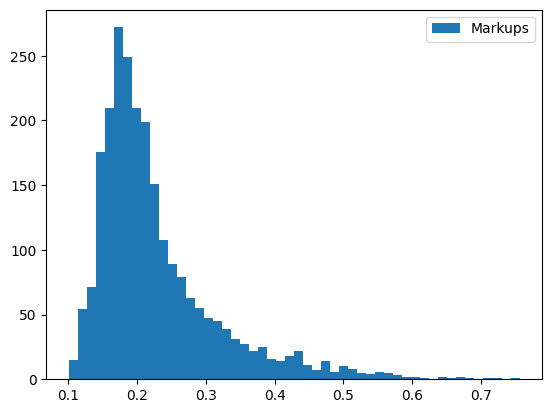

In [ ]:
costs = res_joint.compute_costs()
hhi = res_joint.compute_hhi()
profits = res_joint.compute_profits(costs=costs)
cs = res_joint.compute_consumer_surpluses()

markups = res_joint.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

[[4.47564894]
 [2.85073895]
 [2.59579308]
 ...
 [5.25075433]
 [3.30550709]
 [3.04099446]]


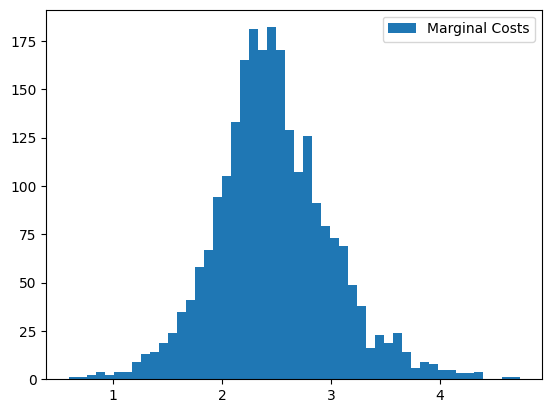

In [ ]:
product_data_11 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_11['merger_ids'] = product_data_11['firm_ids'].replace(2, 1)

changed_prices_11 = res_joint.compute_prices(
    firm_ids=product_data_11['merger_ids'],
    costs=costs
)
print(changed_prices_11)

changed_shares = res_joint.compute_shares(changed_prices_11)



### 12

[[3.58382498]
 [2.83313917]
 [2.59659096]
 ...
 [5.14590258]
 [3.31221369]
 [3.03997887]]


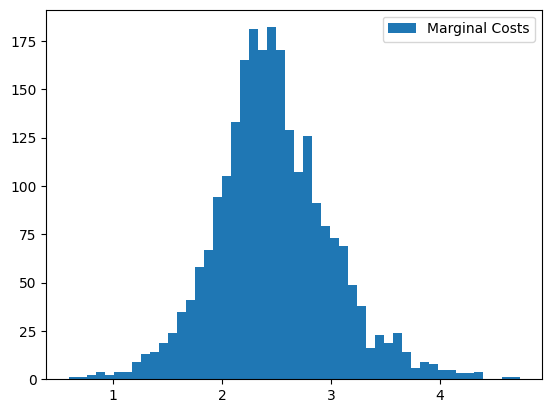

In [ ]:
product_data_12 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_12['merger_ids'] = product_data_12['firm_ids'].replace(3, 1)

changed_prices_12 = res_joint.compute_prices(
    firm_ids=product_data_12['merger_ids'],
    costs=costs
)
print(changed_prices_12)

changed_shares = res_joint.compute_shares(changed_prices_12)



In [ ]:
base_prices = product_data['prices'].values[:,None]  # shape (T*J,)

# --- Merger 11 results (you already computed changed_prices_11) ---
delta_11 = changed_prices_11 - base_prices  # price change after merger 11

# --- Merger 12 results (you computed changed_prices_12 above) ---
delta_12 = changed_prices_12 - base_prices  # price change after merger 12


df_compare = pd.DataFrame({
    'market_id': product_data['market_ids'].values,
    'product_id': product_data['product_ids'].values,
    'baseline_price': base_prices[:,0],
    'post_merger_price_11': changed_prices_11[:,0],
    'post_merger_price_12': changed_prices_12[:,0],
    'delta_price_11': delta_11[:,0],
    'delta_price_12': delta_12[:,0]
})

# Average across markets: one row per product_id
avg_changes = df_compare.groupby('product_id')[['delta_price_11','delta_price_12']].mean()

# Rename columns for clarity in the table
avg_changes = avg_changes.rename(columns={
    'delta_price_11': 'Avg $\\Delta$Price: M. 11',
    'delta_price_12': 'Avg $\\Delta$Price: M. 12'
})

# Optional: add % changes too (across markets, average of \\%$\\Delta$p)
df_compare['pct_delta_11'] = delta_11 / base_prices * 100.0
df_compare['pct_delta_12'] = delta_12 / base_prices * 100.0
avg_pct_changes = df_compare.groupby('product_id')[['pct_delta_11','pct_delta_12']].mean()

avg_pct_changes = avg_pct_changes.rename(columns={
    'pct_delta_11': 'Avg \\%$\\Delta$Price: M. 11',
    'pct_delta_12': 'Avg \\%$\\Delta$Price: M. 12'
})

# Final table: merge levels and round
final_table = avg_changes.merge(
    avg_pct_changes,
    left_index=True,
    right_index=True
).round(4)

# Give nicer product labels
final_table.index.name = 'Product'
final_table.reset_index(inplace=True)

print(final_table)

final_table.to_latex(
    "latex/table_exercise_12.tex",
    index=False,
    float_format="%.4f",
    caption="Average Price Changes Due to Mergers",
    label="tab:exercise_12"
)


   Product  Avg $\Delta$Price: M. 11  Avg $\Delta$Price: M. 12  \
0        1                    0.4074                    0.0589   
1        2                    0.4022                    0.0068   
2        3                    0.0021                    0.0717   
3        4                    0.0021                    0.0011   

   Avg \%$\Delta$Price: M. 11  Avg \%$\Delta$Price: M. 12  
0                     12.9108                      1.8786  
1                     12.5256                      0.2169  
2                      0.0680                      2.2752  
3                      0.0683                      0.0340  


### 14

[[4.10074814]
 [2.71957465]
 [2.59402484]
 ...
 [4.78326555]
 [3.29760784]
 [3.03490792]]


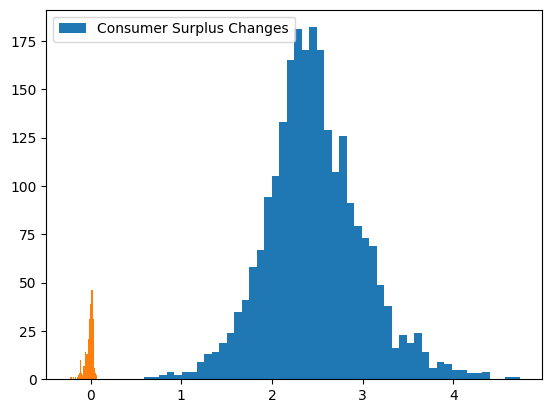

In [ ]:
product_data_14 = product_data.copy()
merged_costs = costs.copy()
plt.hist(merged_costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_14['merger_ids'] = product_data_14['firm_ids'].replace(2, 1)

merged_costs[product_data_14.merger_ids== 1]= 0.85*merged_costs[product_data_14.merger_ids== 1]

changed_prices_14 = res_joint.compute_prices(
    firm_ids=product_data_14['merger_ids'],
    costs=merged_costs
)
print(changed_prices_14)

changed_shares = res_joint.compute_shares(changed_prices_14)
profit_changed = res_joint.compute_profits(costs=merged_costs, prices=changed_prices_14)

changed_cs = res_joint.compute_consumer_surpluses(changed_prices_14)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [ ]:
delta_14 = changed_prices_14 - base_prices  # price change after merger 14


df_compare_14 = pd.DataFrame({
    'market_id': product_data['market_ids'].values,
    'product_id': product_data['product_ids'].values,
    'baseline_price': base_prices[:,0],
    'post_merger_price_11': changed_prices_11[:,0],
    'post_merger_price_12': changed_prices_12[:,0],
    'post_merger_price_14': changed_prices_14[:,0],
    'delta_price_11': delta_11[:,0],
    'delta_price_12': delta_12[:,0],
    'delta_price_14': delta_14[:,0]
})

# Average across markets: one row per product_id
avg_changes = df_compare_14.groupby('product_id')[['delta_price_11','delta_price_12','delta_price_14']].mean()

# Rename columns for clarity in the table
avg_changes = avg_changes.rename(columns={
    'delta_price_11': '$\\Delta$Price: M.11',
    'delta_price_12': '$\\Delta$Price: M.12',
    'delta_price_14': '$\\Delta$Price: M.14'
})

# Optional: add % changes too (across markets, average of %Δp)
df_compare_14['pct_delta_11'] = delta_11 / base_prices * 100.0
df_compare_14['pct_delta_12'] = delta_12 / base_prices * 100.0
df_compare_14['pct_delta_14'] = delta_14 / base_prices * 100.0
avg_pct_changes = df_compare_14.groupby('product_id')[['pct_delta_11','pct_delta_12','pct_delta_14']].mean()

avg_pct_changes = avg_pct_changes.rename(columns={
    'pct_delta_11': '\\%$\\Delta$Price: M.11',
    'pct_delta_12': '\\%$\\Delta$Price: M.12',
    'pct_delta_14': '\\%$\\Delta$Price: M.14'
})

# Final table: merge levels and round
final_table = avg_changes.merge(
    avg_pct_changes,
    left_index=True,
    right_index=True
).round(4)


final_table.to_latex(
    "latex/table_exercise_14.tex",
    index=False,
    float_format="%.4f",
    caption="Average Price Changes Due to Mergers",
    label="tab:exercise_14"
)




In [ ]:
profits = res_joint.compute_profits(costs=costs)
cs = res_joint.compute_consumer_surpluses()
total_welfare = cs.sum() / T
total_welfare_cs =  profit_changed.sum() / T

out_path = Path("latex/scalars_exercise_15.tex").resolve()
latex_str = f"\\newcommand{{\\TotalWelfare}}{{{total_welfare:.3f}}}\n"
latex_str_changed_cs = f"\\newcommand{{\\TotalWelfareChangedCS}}{{{(total_welfare_cs):.3f}}}\n"
latex_str_difference = f"\\newcommand{{\\WelfarePercentage}}{{{((total_welfare_cs/total_welfare -1) * 100):.3f}}}\n"
string = latex_str + "\n" + latex_str_changed_cs + "\n" + latex_str_difference
out_path.write_text(string, encoding="utf-8")
print(f"\nLaTeX scalar written to: {out_path}")



LaTeX scalar written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\scalars_exercise_15.tex
